In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
os.environ["NVIDIA_VISIBLE_DEVICES"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import copy
from torch.nn import functional as F

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['val']}
class_names = image_datasets['val'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



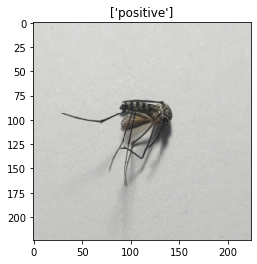

In [4]:
def imshow(inp, title=None, save_path=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [5]:
def visualize_model(model, num_images=6):
#     was_training = model.training
    model.eval()
    images_so_far = 0
#     fig = plt.figure()
    confuse = np.zeros((2,2), dtype=np.int)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            conf, preds = torch.max(F.softmax(outputs, dim=1), 1)
            title = 'predicted: {} Actual: {} Conf.: {:.4f}'.format(class_names[preds[0]],class_names[labels[0]],conf.item())
#             print('predicted: {} Actual: {} Conf.: {:.4f}'.format(class_names[preds[0]],class_names[labels[0]],conf.item()))
            imshow(inputs.cpu().data[0],title,"outputs/{:010d}.png".format((i+1)))
            confuse[labels[0]][preds[0]] += 1
        return confuse

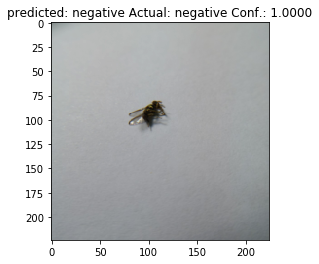

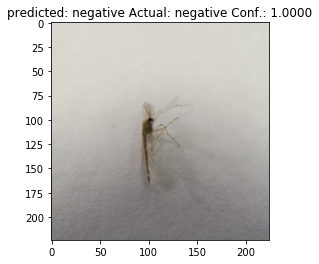

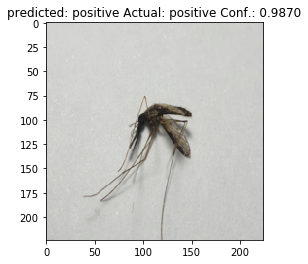

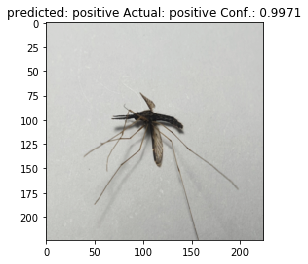

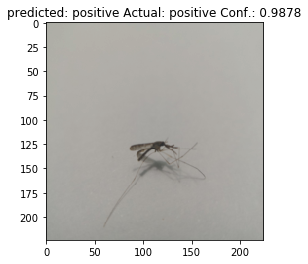

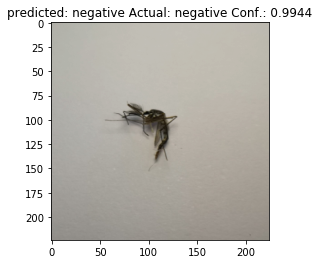

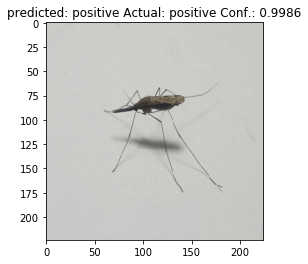

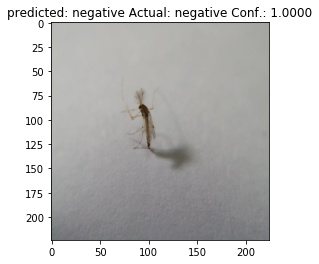

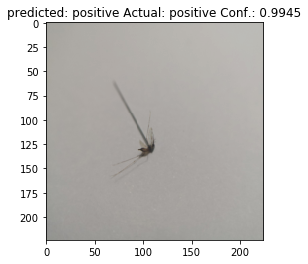

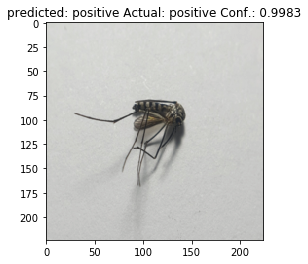

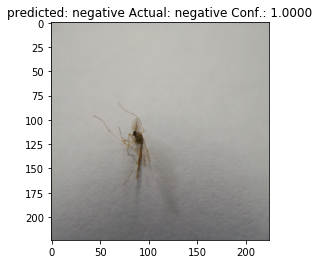

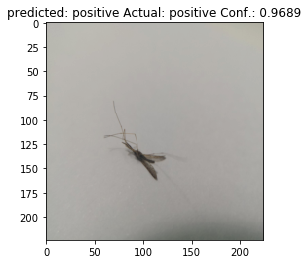

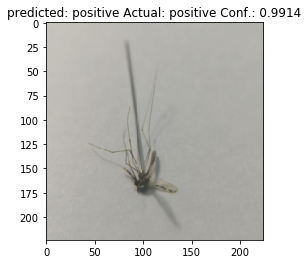

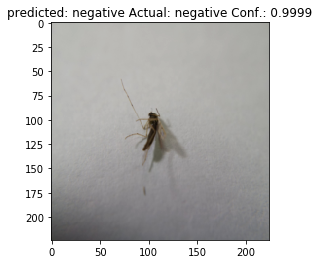

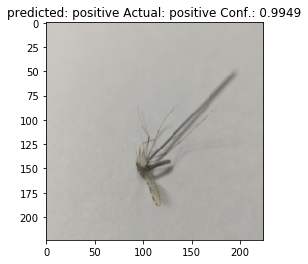

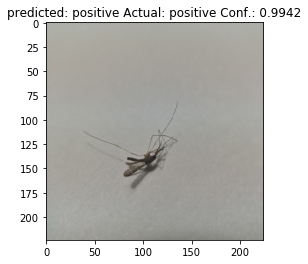

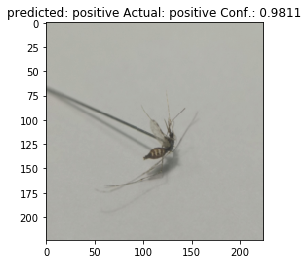

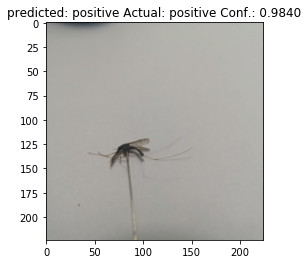

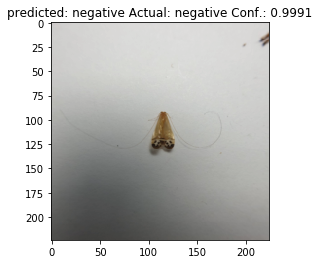

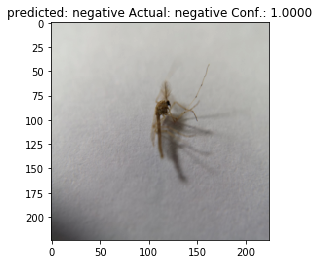

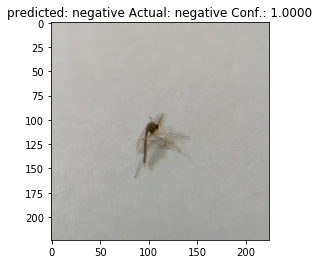

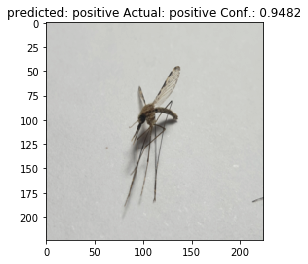

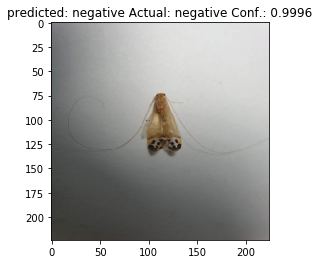

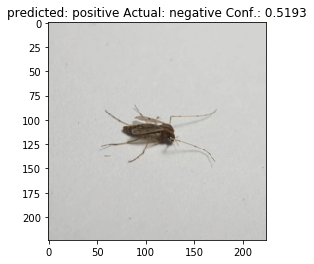

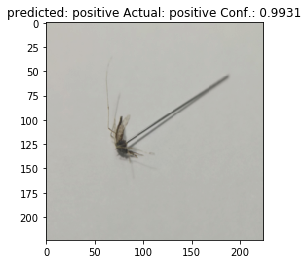

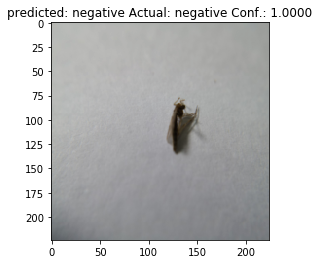

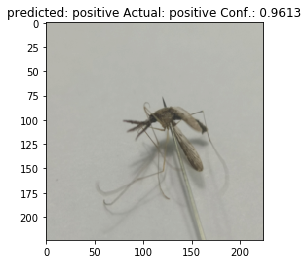

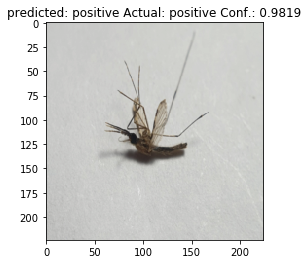

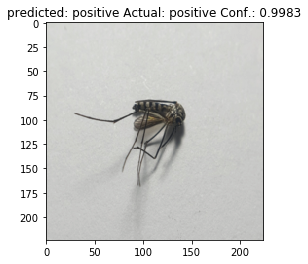

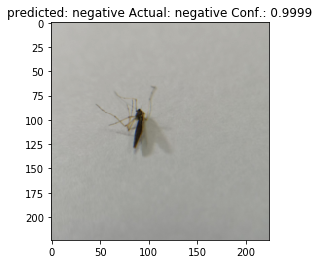

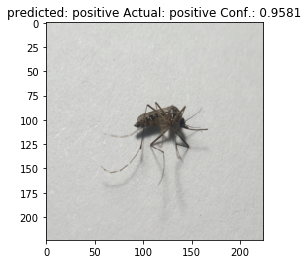

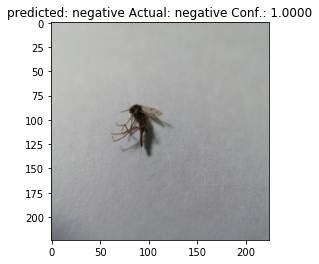

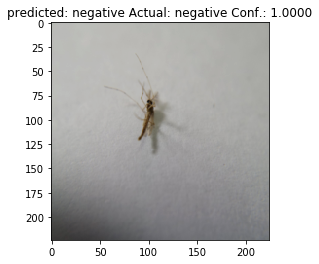

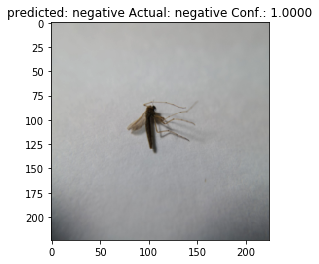

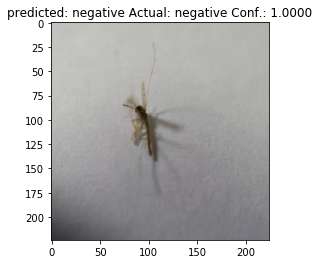

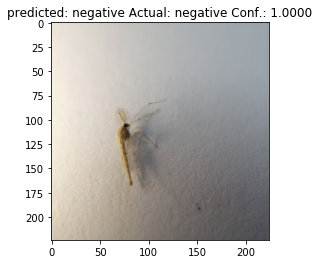

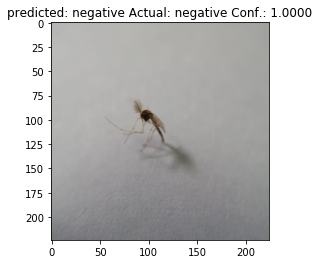

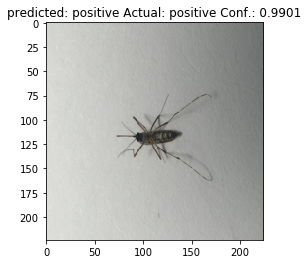

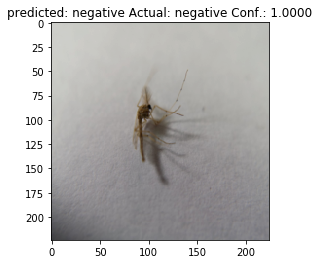

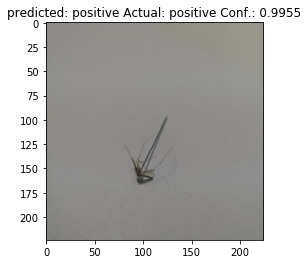

In [6]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft.fc = nn.Linear(num_ftrs, 2)
# model_ft.fc = nn.Sequential(
#                nn.Linear(num_ftrs, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 3))

torch.nn.DataParallel(model_ft).cuda()
# model_ft = model_ft.to(device)

# the_best = torch.load("best_model_wts.pth")
model_ft.load_state_dict(torch.load("best_model_wts.pth",map_location='cuda:0').state_dict())
# print(model_ft.state_dict())

confuse_mat = visualize_model(model_ft)

In [7]:
print(confuse_mat)

[[19  1]
 [ 0 20]]
